In [1]:
import torch 
import torchvision
from torchvision.models.detection.keypoint_rcnn import keypointrcnn_resnet50_fpn
from torchvision import transforms
import skimage
from skimage import io, transform
from matplotlib import pyplot as plt
import numpy as np

In [2]:
model= torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=True)
print(model.parameters)
for param in model.parameters():
    param.requires_grad = False
for param in model.roi_heads.parameters():
    param.requires_grad = True
# for param in model.roi_heads.box_predictor.parameters():
#     param.requires_grad = True
# for param in model.roi_heads.box_head.parameters():
#     param.requires_grad = True
# for param in model.roi_heads.keypoint_predictor.parameters():
#     param.requires_grad = True

#for param in model.roi_heads.parameters():
#    param.requires_grad = True
#print(model.state_dict().keys())
output = model.train()
#print(model.modules)
# print(model.roi_heads.parameters())
# for param in model.roi_heads.parameters():
#     print(param)
#print(model)

<bound method Module.parameters of KeypointRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1

In [3]:
# torch imports
import os.path as osp
import sys
import torch
from torchvision import transforms
from torch.utils.data.dataloader import DataLoader

# root path of project
project_root = osp.join('../..')
sys.path.append(project_root)

from lib.dataset.PoseDataset import PoseDataset
from lib.dataset.custom_transforms import DictToTensor

from references.engine import train_one_epoch, evaluate
from references.utils import collate_fn

In [4]:
transform=transforms.Compose([DictToTensor()])
dataset = PoseDataset(['../../data/vzf/breaststroke/breaststroke_1'], 3, transform=transform)
#dataset = PoseDataset(['../../data/vzf/breaststroke/breaststroke_1'], 3, transform=transform)
dataset[7]
print(dataset.keypoints)
# for i in range(0,len(dataset)):
#     sample = dataset[i]
#     print(str(i))
#     image = sample['image'].to(device)
    

{'0': 'Nose', '1': 'left_eye', '2': 'right_eye', '3': 'left_ear', '4': 'right_ear', '5': 'Shoulder_Close', '6': 'Shoulder_Far', '7': 'Elbow_Close', '8': 'Elbow_Far', '9': 'Wrist_Close', '10': 'Wrist_Far', '11': 'Hip_Close', '12': 'Hip_Far', '13': 'Knee_Close', '14': 'Knee_Far', '15': 'Ankle_Close', '16': 'Ankle_Far'}


In [5]:


# for idx in range(0,2):
#     axarr[idx].imshow(heatmaps[idx].squeeze())
# plt.show()


In [6]:
# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset_train = torch.utils.data.Subset(dataset, indices[:-5])
dataset_test = torch.utils.data.Subset(dataset, indices[-5:])

data_loader_train = torch.utils.data.DataLoader(
        dataset_train, batch_size=10, shuffle=False, num_workers=4,
        collate_fn=collate_fn)

data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=5, shuffle=False, num_workers=4,
        collate_fn=collate_fn)

In [7]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


params = [p for p in model.parameters() if p.requires_grad]         

optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


for epoch in range(0, 5):
    train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=1)
    lr_scheduler.step()
    evaluate(model, data_loader_test, device=device)
torch.save(model.state_dict(), "./weights_breaststroke_epoch{}.wth".format(epoch))

Epoch: [0]  [0/6]  eta: 0:08:11  lr: 0.001004  loss: 5.9425 (5.9425)  loss_classifier: 0.0394 (0.0394)  loss_box_reg: 0.0258 (0.0258)  loss_keypoint: 5.8338 (5.8338)  loss_objectness: 0.0147 (0.0147)  loss_rpn_box_reg: 0.0287 (0.0287)  time: 81.9710  data: 1.1293
Epoch: [0]  [1/6]  eta: 0:07:18  lr: 0.002003  loss: 5.8552 (5.8988)  loss_classifier: 0.0329 (0.0361)  loss_box_reg: 0.0207 (0.0233)  loss_keypoint: 5.7796 (5.8067)  loss_objectness: 0.0035 (0.0091)  loss_rpn_box_reg: 0.0185 (0.0236)  time: 87.7467  data: 0.5661
Epoch: [0]  [2/6]  eta: 0:06:00  lr: 0.003002  loss: 5.8552 (5.7895)  loss_classifier: 0.0390 (0.0371)  loss_box_reg: 0.0243 (0.0236)  loss_keypoint: 5.7796 (5.6983)  loss_objectness: 0.0048 (0.0077)  loss_rpn_box_reg: 0.0212 (0.0228)  time: 90.0735  data: 0.3813
Epoch: [0]  [3/6]  eta: 0:04:28  lr: 0.004001  loss: 5.5707 (5.7068)  loss_classifier: 0.0359 (0.0368)  loss_box_reg: 0.0207 (0.0229)  loss_keypoint: 5.4814 (5.6094)  loss_objectness: 0.0048 (0.0076)  loss_rp

KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), "./weights_4_finally_fixed_interrupted.wth")
 

In [ ]:
annotation_keypoints = {
            '0': "Nose",
            '1': "left_eye",
            '2': "right_eye",
            '3': "left_ear",
            '4': "right_ear",
            '5': "Shoulder_Close",
            '6': "Shoulder_Far",
            '7': "Elbow_Close",
            '8': "Elbow_Far",
            '9': "Wrist_Close",
            '10': "Wrist_Far",
            '11': "Hip_Close",
            '12': "Hip_Far",
            '13': "Knee_Close",
            '14': "Knee_Far",
            '15': "Ankle_Close",
            '16': "Ankle_Far",
        }

In [35]:
model.load_state_dict(torch.load("././weights_4_finally_fixed_interrupted.wth"))
image = io.imread("./swimmer9.jpg")
image_tensor = transforms.ToTensor()(image)
model.eval()
prediction = model([image_tensor])
#print(prediction)


1
0.791295051574707
['Nose']
['left_eye']
['right_eye']
['left_ear']
['right_ear']
['Shoulder_Close']
['Shoulder_Far']
['Elbow_Far']
['Wrist_Close']
['Wrist_Far']
['Hip_Close']
['Hip_Far']
['Knee_Close']
['Knee_Far']
['Ankle_Close']
['Ankle_Far']


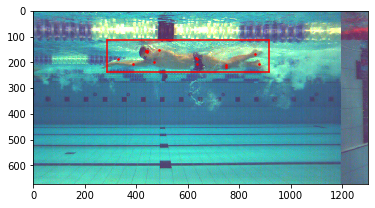

In [40]:
keypoints_scores = prediction[0]['keypoints_scores']
#print('len keypoints : {}'.format(len(keypoints)))
boxes = prediction[0]['boxes']
labels = prediction[0]['labels']
scores = prediction[0]['scores']
keypoints = prediction[0]['keypoints']

fig, ax = plt.subplots()

plt.imshow(image_tensor.permute(1,2,0).detach().numpy())
max_score = 0
max_box = []
for idx, box in enumerate(boxes):
    if scores[idx].item() > max_score:
        print(labels[idx].data.numpy())
        max_score = scores[idx].item()
        max_box = box
        max_keypoints = keypoints[idx] 
        max_keypoints_scores = keypoints_scores[idx]
print(max_score)
#for box in boxes[np.where(scores > .80)]:
#print(max_keypoints[np.argwhere(max_keypoints_scores > 1)])
for box in [max_box]:
    # add keypoints to imag
        # TODO: add color coding for different body parts
        
        # draw lines as specified in skeleton 
    
    plt.plot([box[0], box[2]], [box[1], box[1]], c='r')
    plt.plot([box[0], box[2]], [box[3], box[3]], c='r')
    plt.plot([box[0], box[0]], [box[1], box[3]], c='r')
    plt.plot([box[2], box[2]], [box[1], box[3]], c='r')

    min_keypoint_score = 0


    keypoints_min_score = max_keypoints[[np.argwhere(max_keypoints_scores.detach().numpy() > min_keypoint_score)]].detach().numpy()
    annotations_min_score = np.array(list(annotation_keypoints.values()))[[np.argwhere(max_keypoints_scores.detach().numpy() > min_keypoint_score)]]

    # print(max_keypoints_scores.detach().numpy())
    # print([np.argwhere(max_keypoints_scores.detach().numpy() > 5)])
    # print(max_keypoints[[np.argwhere(max_keypoints_scores.detach().numpy() > 5)]].detach().numpy())
    ax.scatter(np.array(keypoints_min_score)[:,0,0],np.array(keypoints_min_score)[:,0,1], s=10, marker='.', c='r')

    # annotate points on image
    for i, annotation in enumerate(annotations_min_score):
        print(annotation)
    #     ax.annotate(annotation, (np.array(keypoints_min_score)[i,0,0], np.array(keypoints_min_score)[i,0,1]))

        # pause a bit so that plots are updated
plt.pause(0.001)  
        
        # display
plt.show(block=True)

In [28]:
model_keypoint = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=True)

In [ ]:
image = io.imread("./swimmer3.jpg")
image_tensor = transforms.ToTensor()(image)
model_keypoint.eval()
prediction = model_keypoint([image_tensor])
boxes = prediction[0]['boxes']
labels = prediction[0]['labels']
scores = prediction[0]['scores']
keypoints = prediction[0]['keypoints']
keypoints_scores = prediction[0]['keypoints_scores']
plt.figure()
# show image
plt.imshow(image_tensor.permute(1,2,0).detach().numpy())
max_score = 0
max_box = []
for idx, box in enumerate(boxes):
    if scores[idx].item() > max_score:
        print(labels[idx].data.numpy())
        max_score = scores[idx].item()
        max_box = box
        max_keypoints = keypoints[idx] 
        max_keypoints_scores = keypoints_scores[idx]
print(max_score)
#for box in boxes[np.where(scores > .50)]:

for box in [max_box]:
    # add keypoints to imag
        # TODO: add color coding for different body parts
        
        # draw lines as specified in skeleton 
    
    plt.plot([box[0], box[2]], [box[1], box[1]], c='r')
    plt.plot([box[0], box[2]], [box[3], box[3]], c='r')
    plt.plot([box[0], box[0]], [box[1], box[3]], c='r')
    plt.plot([box[2], box[2]], [box[1], box[3]], c='r')
    #for keypoint in max_keypoints[5:]:
    #     plt.scatter(np.array(max_keypoints.detach().numpy())[:,0],np.array(max_keypoints.detach().numpy())[:,1], s=10, marker='.', c='r')\
    keypoints_min_score = max_keypoints[[np.argwhere(max_keypoints_scores.detach().numpy() > 0)]].detach().numpy()
    print(max_keypoints_scores.detach().numpy())
    print([np.argwhere(max_keypoints_scores.detach().numpy() > 5)])
    print(max_keypoints[[np.argwhere(max_keypoints_scores.detach().numpy() > 0)]].detach().numpy())
    plt.scatter(np.array(keypoints_min_score)[:,0,0],np.array(keypoints_min_score)[:,0,1], s=10, marker='.', c='r')

        # pause a bit so that plots are updated
plt.pause(0.001)  
        
        # display
plt.show(block=True)